In [1]:
import pandas as pd

import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

from scipy import stats

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

#from google.colab import files

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.svm import SVC 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import export_graphviz
from sklearn.datasets import make_classification, make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
import tensorflow as tf

%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')

# Data Preprocessing

## Step 1 - Finding Null values
- Training Set
- Test Set

Training Set


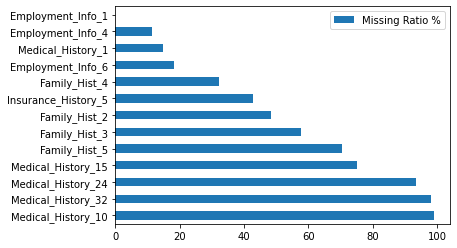




Test Set


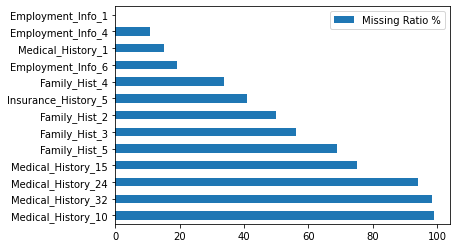

In [4]:
print("Training Set")
plot_nas(train_df)
print("\n\n")
print("Test Set")
plot_nas(test_df)

### Here we set our null value threshold to 40% and remove all the features above the threshhold. The features below the threshold will be imputed by calculating their skewness and the imputing null values with mean (if data is not skewed), median (data is skewed and feature is in numerical format) and mode (if data is skewed and the feature is in categorical format). Some measure skewness when mean == median

Training Set


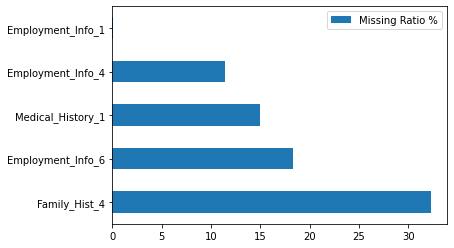

Test Set


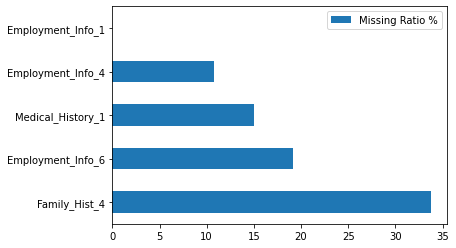

In [5]:
train_df = train_df.drop(['Insurance_History_5','Family_Hist_2','Family_Hist_3', 'Family_Hist_5', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32', 'Medical_History_10'], axis=1)
test_df = test_df.drop(['Insurance_History_5','Family_Hist_2','Family_Hist_3', 'Family_Hist_5', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32', 'Medical_History_10'], axis=1)

print("Training Set")
plot_nas(train_df)
print("Test Set")
plot_nas(test_df)

Mean:  0.07758209953084522
Median:  0.06


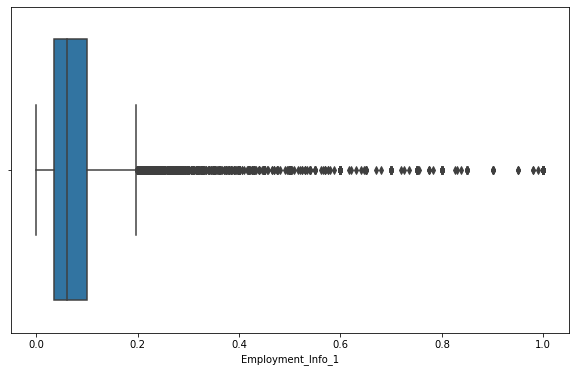

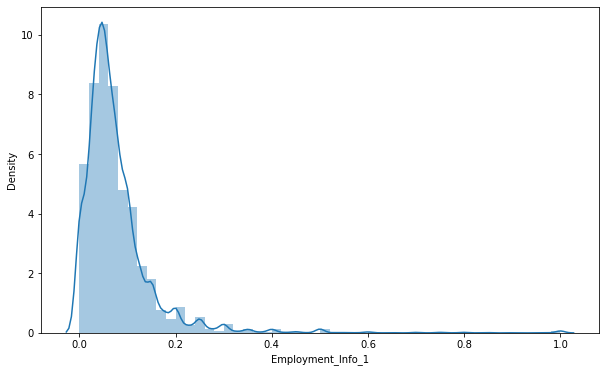

In [6]:
cols = ['Employment_Info_1', 'Employment_Info_4', 'Medical_History_1', 'Employment_Info_6', 'Family_Hist_4']

fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(train_df[cols[0]])

fig, ax = plt.subplots(figsize = (10,6))
sns.distplot(train_df[cols[0]])

print("Mean: ",train_df[cols[0]].mean())
print("Median: ",train_df[cols[0]].median())

#Since the data is skewed towards left, we use mean to impute data
mean = train_df[cols[0]].mean()
train_df[cols[0]] = train_df[cols[0]].fillna(mean)

#Since the data values in all cells are either 0 or very close to 0 we'll drop the column 
train_df = train_df.drop([cols[1]], axis=1)
test_df = test_df.drop([cols[1]], axis=1)

#Since the data is skewed towards left, we use mean to impute data
mean = train_df[cols[2]].mean()
train_df[cols[2]] = train_df[cols[2]].fillna(mean)

#Since the data is skewed towards left, we use mean to impute data
mean = train_df[cols[3]].mean()
train_df[cols[3]] = train_df[cols[3]].fillna(mean)

#Since the data is skewed and follows normal distribution i.e mean == median, we use median (numeric) and median (categorical) to impute data
mean = train_df[cols[4]].median()
train_df[cols[4]] = train_df[cols[4]].fillna(mean)

#Test Dataset
cols_test = ['Medical_History_1', 'Employment_Info_6', 'Family_Hist_4', 'Employment_Info_1']

#Since the data is skewed towards left, we use mean to impute data
mean = test_df[cols_test[0]].mean()
test_df[cols_test[0]] = test_df[cols_test[0]].fillna(mean)

#Since the data is skewed towards left, we use mean to impute data
mean = test_df[cols_test[1]].mean()
test_df[cols_test[1]] = test_df[cols_test[1]].fillna(mean)

#Since the data is normal, we use median to impute data
mean = test_df[cols_test[2]].median()
test_df[cols_test[2]] = test_df[cols_test[2]].fillna(mean)

#Since the data is skewed towards left, we use mean to impute data
mean = test_df[cols_test[3]].mean()
test_df[cols_test[3]] = test_df[cols_test[3]].fillna(mean)

In [7]:
plot_nas(train_df)
plot_nas(test_df)

No NAs found
No NAs found


## Label Encoding on categorical Column

In [8]:
labelencoder = preprocessing.LabelEncoder()

train_df['Product_Info_2'] = labelencoder.fit_transform(train_df['Product_Info_2'])
test_df['Product_Info_2'] = labelencoder.fit_transform(test_df['Product_Info_2'])
train_df['Product_Info_2']

0        16
1         0
2        18
3        17
4        15
         ..
59376    14
59377    16
59378    18
59379    15
59380     7
Name: Product_Info_2, Length: 59381, dtype: int32

### We will now remove outliers, but before that we will store the dataframe with outliers, which we will use further to check if we just need to check for outliers

In [9]:
test_df_outliers = test_df
train_df_outliers = train_df

def box_plot(df, feature):
    df.boxplot(column = feature)
    plt.grid(False)
    plt.show()

def outliers(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)

    inter_quantile_range = q3 - q1

    #here 1.5 being the default scale value
    lower_boundary = q1 - 1.5 * inter_quantile_range
    upper_bounary =  q3 + 1.5 * inter_quantile_range

    outliers_index = df.index[(df[feature] < lower_boundary) | (df[feature] > upper_bounary)]
    return outliers_index

def remove_out(df, indexlst):
    #sort the list and remove duplicate values && set returns non-repeating elements
    indexlst = sorted(set(indexlst))
    df = df.drop(indexlst)
    return df

In [10]:
cols = train_df.columns
cols_lst = cols.tolist()
cols_lst.remove('Product_Info_2')
cols_lst.remove('Response')

index_list = []

#Here we will xclude Response since it is target variable
for feature in cols_lst:
  # .append() adds a single element to the end of the list while .extend() can add multiple individual elements to the end of the list.
  index_list.extend(outliers(train_df, feature))

In [11]:
df_cleaned = remove_out(train_df, index_list)
df_cleaned

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
52,76,1,16,26,0.076923,2,3,1,0.402985,0.781818,...,0,0,0,0,0,0,0,0,0,6
74,108,1,15,26,0.128205,2,3,1,0.626866,0.709091,...,0,0,0,0,0,0,0,0,0,6
83,118,1,17,26,0.230769,2,3,1,0.164179,0.763636,...,0,0,0,0,0,0,0,0,0,7
94,132,1,17,26,0.282051,2,3,1,0.283582,0.763636,...,0,0,0,0,0,0,0,0,0,6
161,221,1,16,26,0.076923,2,3,1,0.567164,0.654545,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59299,79044,1,17,26,0.230769,2,3,1,0.298507,0.581818,...,0,0,0,0,0,0,0,0,0,8
59323,79079,1,14,26,0.333333,2,3,1,0.119403,0.727273,...,0,0,0,0,0,0,0,0,0,7
59331,79092,1,0,26,0.230769,2,3,1,0.119403,0.672727,...,0,0,0,0,0,0,0,0,0,8
59345,79109,1,14,26,0.076923,2,3,1,0.477612,0.709091,...,0,0,0,0,0,0,0,0,0,4


## We will now check for Correlation and drop features with least correlation

Text(0.5, 1.0, 'Correlation between different features')

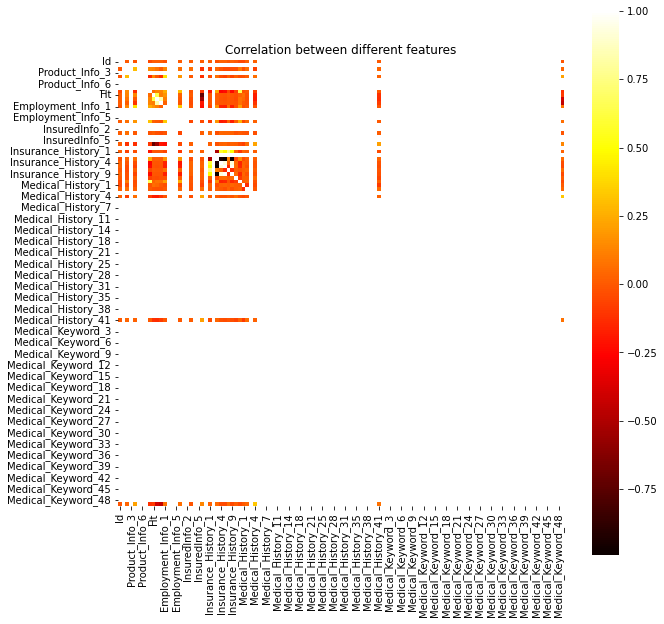

In [12]:
correlation = df_cleaned.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True, cmap='hot')

plt.title('Correlation between different features')

### Since the feature set is large and we cannot deduce the correlation we calculate feature score using Mutual independence Chi-square

<AxesSubplot:>

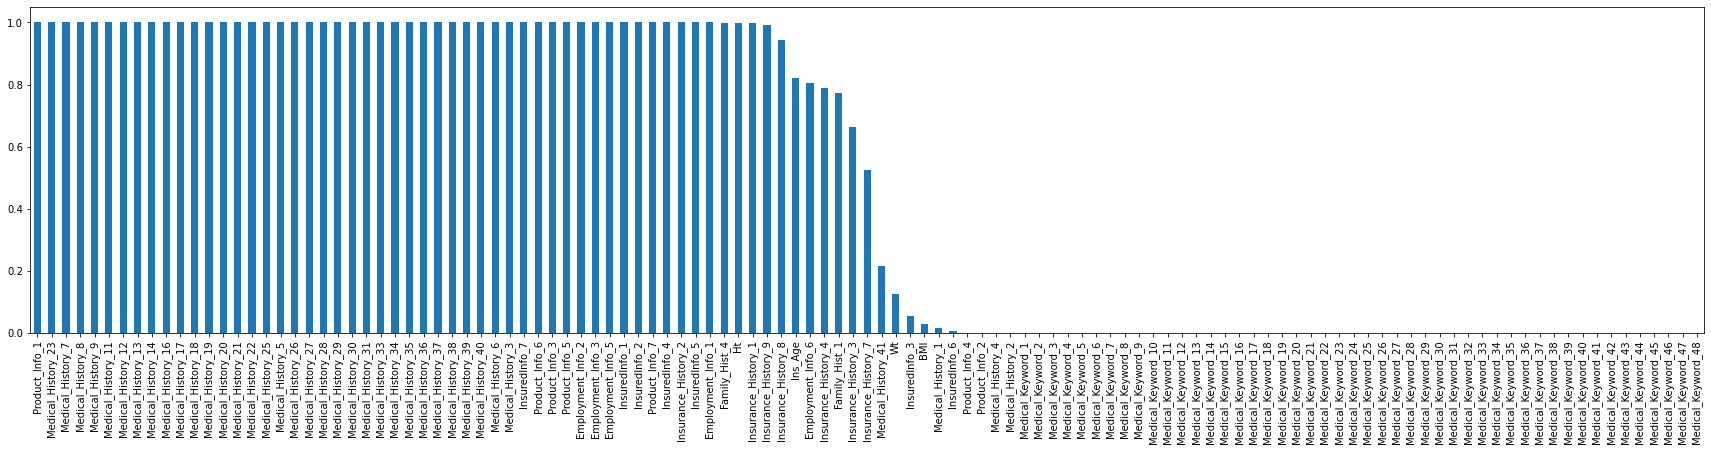

In [13]:
response_train = df_cleaned['Response']
y = df_cleaned['Response']
X = df_cleaned.drop(['Id', 'Response'], axis=1)

chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
fig, ax = plt.subplots(figsize = (30,6))
p_values.plot.bar()

### Now as we can see some columns have very low importance so we can drop them and then Normalise the data

In [14]:
col_drop = []
col_drop.append('Product_Info_4')
col_drop.append('Product_Info_2')
col_drop.append('Medical_History_2')
col_drop.append('Medical_History_4')
for i in range(1,49):
    a = "Medical_Keyword_"+str(i)
    col_drop.append(a)

df_cleaned = df_cleaned.drop(col_drop, axis=1)
print(df_cleaned.shape)
cols = df_cleaned.columns

#Test data
test_df = test_df.drop(col_drop, axis=1)
print("Test Data: ",test_df.shape)

d = preprocessing.normalize(df_cleaned)
scaled_df = pd.DataFrame(d, columns=cols)

d1 = preprocessing.normalize(test_df)
test_df = pd.DataFrame(d1, columns=test_df.columns)

scaled_df

(2000, 67)
Test Data:  (19765, 66)


,Id,Product_Info_1,Product_Info_3,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,...,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Response
0,0.915366,0.012044,0.313151,0.024089,0.036133,0.012044,0.004854,0.009416,0.004737,0.006692,...,0.036133,0.036133,0.012044,0.024089,0.024089,0.012044,0.036133,0.036133,0.012044,0.072266
1,0.956770,0.008859,0.230334,0.017718,0.026577,0.008859,0.005553,0.006282,0.003299,0.005394,...,0.026577,0.026577,0.008859,0.017718,0.017718,0.008859,0.026577,0.026577,0.008859,0.053154
2,0.955623,0.008099,0.210561,0.016197,0.024296,0.008099,0.001330,0.006184,0.002931,0.004268,...,0.024296,0.024296,0.008099,0.016197,0.016197,0.008099,0.024296,0.024296,0.008099,0.056690
3,0.970480,0.007352,0.191155,0.014704,0.022056,0.007352,0.002085,0.005614,0.002569,0.003730,...,0.022056,0.022056,0.007352,0.014704,0.014704,0.007352,0.022056,0.022056,0.007352,0.044113
4,0.989210,0.004476,0.116378,0.008952,0.013428,0.004476,0.002539,0.002930,0.000824,0.001476,...,0.013428,0.013428,0.004476,0.008952,0.008952,0.004476,0.013428,0.013428,0.013428,0.031332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.000000,0.000013,0.000329,0.000025,0.000038,0.000013,0.000004,0.000007,0.000002,0.000004,...,0.000038,0.000038,0.000013,0.000025,0.000025,0.000013,0.000038,0.000038,0.000013,0.000101
1996,1.000000,0.000013,0.000329,0.000025,0.000038,0.000013,0.000002,0.000009,0.000005,0.000007,...,0.000038,0.000038,0.000013,0.000025,0.000025,0.000013,0.000038,0.000038,0.000013,0.000089
1997,1.000000,0.000013,0.000329,0.000025,0.000038,0.000013,0.000002,0.000009,0.000003,0.000004,...,0.000038,0.000038,0.000013,0.000025,0.000025,0.000013,0.000038,0.000038,0.000013,0.000101
1998,1.000000,0.000013,0.000329,0.000025,0.000038,0.000013,0.000006,0.000009,0.000004,0.000006,...,0.000038,0.000038,0.000013,0.000025,0.000025,0.000013,0.000038,0.000038,0.000013,0.000051


In [15]:
response = df_cleaned['Response']
y_train = df_cleaned['Response']
X_train = scaled_df.drop(['Id', 'Response'], axis=1)

test_df.columns
X_test = test_df.drop('Id', axis=1)

### Now we can use GridSearch to crossvalidate the params within multiple models

In [16]:
param_grid= {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],'C': [0.1,1,10,100]}
base_estimator = SVC(gamma='scale')
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

SVC(C=0.1, kernel='poly')

In [17]:
#Support Vector Classification

clf = SVC(kernel='poly', C=0.1)
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print(pred)

[2 7 6 ... 8 8 8]


In [18]:
param_grid= {'C':[0.1,1,10],
    'max_iter':[100,200,300,400],
    'tol':[0.0001,0.001,0.1,1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
base_estimator = LogisticRegression()
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

LogisticRegression(C=0.1, solver='newton-cg')

In [19]:
#Logistic Regression

model= LogisticRegression(multi_class='ovr', solver='newton-cg',C=0.1)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(pred)
pred = list(pred)
pred = pd.DataFrame(pred, columns=['Response'])
pred.to_excel('our_output.xlsx', index = False)

[8 8 8 ... 8 8 8]


In [20]:
param_grid= {'loss': ['squared_error','huber', 'epsilon_insensitive','squared_epsilon_insensitive'],'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 1], 'learning_rate': ['constant','optimal','invscaling','adaptive']}
base_estimator = SGDRegressor()
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

ValueError: The loss squared_error is not supported. 

In [21]:
param_grid= {'loss': ['huber', 'epsilon_insensitive','squared_epsilon_insensitive'],'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 1], 'learning_rate': ['constant','optimal','invscaling','adaptive']}
base_estimator = SGDRegressor()
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

SGDRegressor(alpha=0.01, loss='squared_epsilon_insensitive', penalty='l1')

In [22]:
#Stochastic Gradient Decent Regressor

model= SGDRegressor(alpha=0.001, loss='squared_epsilon_insensitive', penalty='l1')
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(pred)

[6.64510696 6.64510696 6.64510696 ... 6.64510696 6.64510696 6.64510696]


In [23]:
param_grid= {'alpha': [0.1,1,10]}
base_estimator = linear_model.Lasso()
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, y_train)
sh.best_estimator_

Lasso(alpha=0.1)

In [24]:
#Linear Regression

model= LinearRegression()
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(pred)

[ 32.57706055  88.35499502 -83.13209358 ...   6.61507762   6.62056436
   6.58535169]


In [25]:
#Isolation Forest to detect anomalies using isolation rather than modeling the normal points.

model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(X_test)

IsolationForest(contamination=0.1, n_estimators=50)

         scores  anomaly
0     -0.411597       -1
1     -0.409194       -1
2     -0.411597       -1
3     -0.407995       -1
4     -0.412800       -1
...         ...      ...
19760  0.119986        1
19761  0.124978        1
19762  0.126932        1
19763  0.120013        1
19764  0.124742        1

[19765 rows x 2 columns]


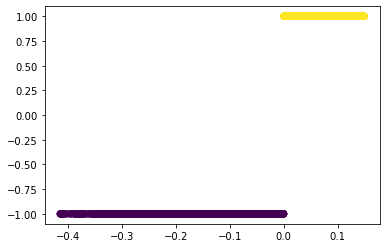

In [26]:
df = pd.DataFrame()
df['scores']=model.decision_function(X_test)
df['anomaly']=model.predict(X_test)
print(df)
plt.scatter(df['scores'], df['anomaly'], c=df['anomaly'])